## A recall on our Random Sampling plus Fake Data (RS+FD) approach in comparison with the state-of-the-art methods: splitting the privacy budget per attribute (Spl) or random sampling a single attribute and sending it with the whole privacy budget (Smp)

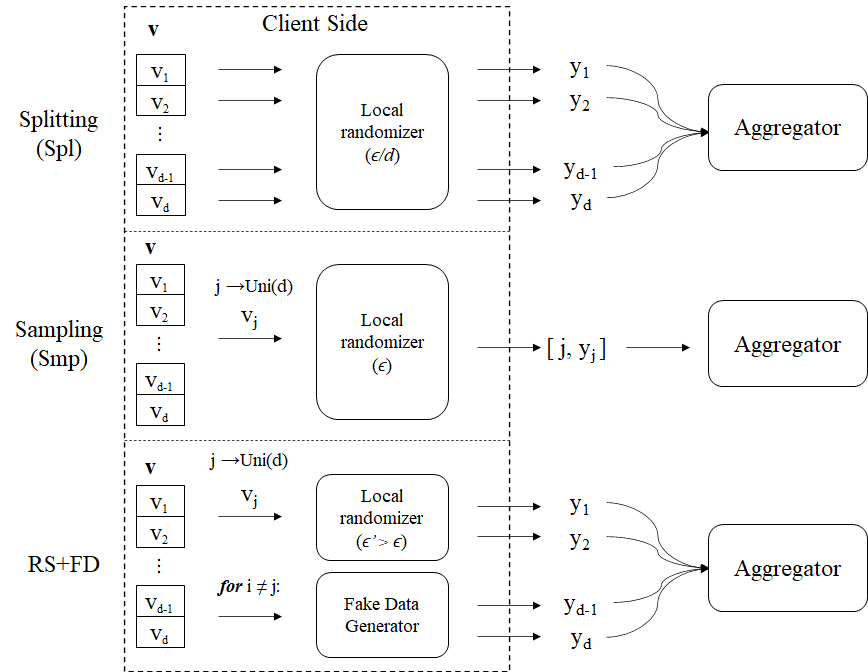

## Number of evaluations (i.e., of different seeds)

In [1]:
nb_seed = 100

## Functions to save results in csv format per method

In [2]:
def write_rs_fd_adp(values):
        with open('results/vhs/final_results_rs_fd_adp.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()

def write_rs_fd_grr(values):
        with open('results/vhs/final_results_rs_fd_grr.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()
        
def write_rs_fd_oue_z(values):
        with open('results/vhs/final_results_rs_fd_oue_z.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()        

def write_rs_fd_oue_r(values):
        with open('results/vhs/final_results_rs_fd_oue_r.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()

def write_spl_adp(values):
        with open('results/vhs/final_results_spl_adp.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()     
        
def write_smp_adp(values):
        with open('results/vhs/final_results_smp_adp.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()

## Numba library for speeding up things

In [3]:
from numba import jit

## GRR functions

In [4]:
@jit(nopython=True)
def GRR(x, lst_val, p, q):
    """
    GRR mechanism
    input: true value x, domain values 'lst_val', and probabilities p,q
    output: true value w.p. 'p', random value (except x) w.p. 'q'
    """
    
    rnd = np.random.random()

    if rnd <=p:    
        return x
    else:
        return np.random.choice(lst_val[lst_val !=x]) 


def SB_GRR(p, q , lst_val, lst):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: probabilities p and q, domain values 'lst_val', and the list of reports 'lst'
    output: estimated frequency
    """
    
    n = len(lst)
    
    Ni = {val:0 for val in lst_val}
    
    for val in lst: #how many times each value has been reported
        Ni[val]+=1
    
    for key in Ni.keys(): #estimated number of times with Eq. (1)
        est = (Ni[key] - n*q) / (p-q)
        if est > 0:
            Ni[key] = est
        else: # if negative, we'll clip to 0 and re-normalize.
            Ni[key] = 0
    total = sum(Ni.values()) #for re-normalization
    for key in Ni.keys():
        Ni[key] = Ni[key]/total
    return np.array(list(Ni.values()))

## UE functions

In [5]:
@jit(nopython=True)
def UE(arr, p, q):
    """
    OUE mechanism
    input: encoded true value arr and probabilities p and q
    output: sanitized array 'rep'
    """
    
    size=len(arr)
    rep = np.zeros(size)
    
    for ind in range(size):
        if arr[ind] != 1:
            rnd = np.random.random()
            if rnd <= q:
                rep[ind] = 1       
        else:
            rnd = np.random.random()
            if rnd <= p:
                rep[ind] = 1
    return rep

def SB_UE(p, q, lst_val, lst):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: probabilities p and q, domain values 'lst_val', and the list of reports 'lst'
    output: estimated frequency
    """
    
    n = len(lst)
    
    est = np.array((sum(lst) - q * n) / (p-q)).clip(0) #estimated number with Eq. (1) clipped in 0 for re-normalization
    
    freq_est = est / sum(est) #re-normalized estimated frequency
    
    return freq_est

## Main libraries

In [6]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd; pd.set_option('mode.chained_assignment',None)
#pd.set_option('display.max_rows', 500)
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import copy
from scipy.stats import bernoulli
import datetime
import time
import csv
from pandas.core.common import flatten

## The dataset we use is from: https://github.com/hharcolezi/OpenMSFIMU

### Reading dataset

In [7]:
url = "https://raw.githubusercontent.com/hharcolezi/OpenMSFIMU/master/Data/Personal_table.csv"

fimu=['2017-05-31','2017-06-01','2017-06-02','2017-06-03','2017-06-04','2017-06-05','2017-06-06']

df = pd.read_csv(url, error_bad_lines=False)
df.reset_index(inplace=True, drop=True)
df

,Person ID,Name,Gender,Age,Geolife,Visitor category,Region,Sleeping area
0,7645,Andrea Berry,NR,NR,NR,Foreign tourist,United Kingdom,City of Belfort
1,26771,Elizabeth Palmer,NR,NR,NR,Foreign tourist,Germany,NR
2,38302,Jacob Smith,NR,NR,NR,Foreign tourist,Netherlands,City of Belfort
3,28106,Francisco Blankenship,NR,NR,NR,Foreign tourist,United Kingdom,NR
4,72234,Stephanie Bell DDS,NR,NR,NR,Foreign tourist,United Kingdom,NR
...,...,...,...,...,...,...,...,...
88930,6998,Anastasie Begue,F,55-64,NR,French tourist,Rhône-Alpes,NR
88931,10589,Arthur Maillet5778,M,<18,rural worker,French tourist,Rhône-Alpes,Rest of Doubs
88932,10275,Arnaude du Leleu,F,>65,middle-class urban,French tourist,Rhône-Alpes,NR
88933,19080,Christiane Roy,F,55-64,middle-class urban,French tourist,Rhône-Alpes,City of Belfort


In [9]:
print('Dataset dimension:',df.shape)

Dataset dimension: (88935, 8)


In [10]:
print('Number of unique users:',len(set(df['Person ID'])))

Number of unique users: 88935


In [11]:
df.columns

Index(['Person ID', 'Name', 'Gender', 'Age', 'Geolife', 'Visitor category',
       'Region', 'Sleeping area'],
      dtype='object')

In [12]:
print("Domain size of each category we're interested in:\n")
for col in ['Visitor category','Gender', 'Age', 'Geolife', 'Region','Sleeping area']:
    print(col,':',len(set(df[col])))

Domain size of each category we're interested in:

Visitor category : 3
Gender : 3
Age : 8
Geolife : 12
Region : 37
Sleeping area : 11


## Dataset to work with

In [13]:
attributes = ['Visitor category','Gender', 'Age','Geolife', 'Region','Sleeping area']

df2anon = copy.deepcopy(df[attributes])

LE = LabelEncoder()

lst_label = {val:[] for val in attributes}

for col in attributes:
    df2anon[col] = LE.fit_transform(df[col])
    lst_label[col] = list(set(df2anon[col]))

df = pd.concat([df[['Person ID']],df2anon],axis=1)#,cp
df

,Person ID,Visitor category,Gender,Age,Geolife,Region,Sleeping area
0,7645,0,2,7,0,35,3
1,26771,0,2,7,0,15,4
2,38302,0,2,7,0,22,3
3,28106,0,2,7,0,35,4
4,72234,0,2,7,0,35,4
...,...,...,...,...,...,...,...
88930,6998,1,0,4,0,30,4
88931,10589,1,1,5,9,30,7
88932,10275,1,0,6,7,30,4
88933,19080,1,0,4,7,30,3


## Static parameters

In [14]:
#number of dimensions (d)
d = len(attributes)
print('d=', d)

#number of users (n)
n = df.shape[0]
print('n=',n)

#sampling rate
beta = 1/d
print('beta=', beta)

#range of epsilon used in experiments
lst_eps = [round(np.log(val),4) for val in range(2,8)]
print('epsilon=', lst_eps)

d= 6
n= 88935
beta= 0.16666666666666666
epsilon= [0.6931, 1.0986, 1.3863, 1.6094, 1.7918, 1.9459]


## Real frequency

In [15]:
# For each attribute, count the number of people per value

dic_true = {att:{val:0 for val in np.unique(df[att])} for att in attributes}

for att in attributes:

    dfcp = df.groupby(att).count()
    n = df.shape[0]

    index = 0
    for val in dfcp.index:
        val_true = dfcp.values[index,0]
        dic_true[att][val] += val_true 
        index+=1
dic_true

{'Visitor category': {0: 1837, 1: 41655, 2: 45443},
 'Gender': {0: 45982, 1: 41116, 2: 1837},
 'Age': {0: 8474,
  1: 11115,
  2: 11813,
  3: 12710,
  4: 11907,
  5: 17111,
  6: 13968,
  7: 1837},
 'Geolife': {0: 13922,
  1: 9136,
  2: 1255,
  3: 4949,
  4: 8776,
  5: 11154,
  6: 5348,
  7: 14013,
  8: 8417,
  9: 8107,
  10: 236,
  11: 3622},
 'Region': {0: 45,
  1: 6290,
  2: 279,
  3: 52,
  4: 156,
  5: 702,
  6: 36,
  7: 1395,
  8: 231,
  9: 422,
  10: 642,
  11: 31,
  12: 230,
  13: 198,
  14: 63086,
  15: 424,
  16: 111,
  17: 1900,
  18: 57,
  19: 328,
  20: 1321,
  21: 210,
  22: 69,
  23: 316,
  24: 287,
  25: 160,
  26: 397,
  27: 504,
  28: 2505,
  29: 188,
  30: 5868,
  31: 46,
  32: 9,
  33: 52,
  34: 281,
  35: 74,
  36: 33},
 'Sleeping area': {0: 8771,
  1: 1394,
  2: 4880,
  3: 36612,
  4: 23342,
  5: 633,
  6: 4962,
  7: 2717,
  8: 2711,
  9: 2579,
  10: 334}}

## RS+FD[GRR]

In [16]:
def SB_RSpFD_GRR(total_reports, p, q, lst_val, d, k, n):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: all LDP+fake reports 'total_reports', probabilities p and q, domain values 'lst_val', 
    number of attributes d, number of values of this attribute k, and number of users n
    output: estimated frequency
    """

    Ni = {val:0 for val in lst_val}

    for val in total_reports: #how many times each value has been reported
        Ni[val]+=1

    for key in Ni.keys(): #estimated number of times with Eq. (4)
        val =  ( (Ni[key] * d * k) - n * (d - 1 + q*k)) / (n*k*(p-q)) 
        if val > 0:
            Ni[key] = val
        else: # if negative, we'll clip to 0 and re-normalize.
            Ni[key] = 0
            
    total = sum(Ni.values()) #for re-normalization
    for key in Ni.keys():
        Ni[key] = Ni[key]/total
    return np.array(list(Ni.values()))

In [17]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)

    dic_rsfd_grr = {} # initialize dictionary to save MSE result per epsilon

    for epsilon_tot in lst_eps: #iterate over each epsilon value

        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)     
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        lst_mse_att = [] # given epsilon, initialize a list to save MSE result per attribute

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute
            
            k = len(lst_val)  # domain size of the attribute
            
            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # GRR parameters with amplified epsilon (eps_l)
            p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
            q = (1 - p) / (k - 1)
            
            # list with epsilon-LDP values
            lst_grr = [GRR(val, lst_val, p, q) for val in lst_true]
            
            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)

            lst_fake = [np.random.randint(k) for _ in range(nb_fake)] # uniform fake data on domain k

            total_reports = lst_grr + lst_fake # list of all reports for this attribute (LDP + fake)
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpFD_GRR(total_reports, p, q, lst_val, d, k, n)
            
            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_grr[epsilon_tot] = np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_rs_fd_grr(list(flatten([seed, list(dic_rsfd_grr.values())])))
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
That took 724.773405790329 seconds


## RS+FD[OUE-0]

In [18]:
def SB_RSpFD_OUE_Zero(total_reports, p, q, d, k, n):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: all LDP+fake encoded reports 'total_reports', probabilities p and q, 
    number of attributes d, number of values of this attribute k, and number of users n
    output: estimated frequency
    """
   
    Nb_S = sum(total_reports) #how many times each value has been reported
    
    est =  np.array(d*(Nb_S  - n*q) / (n*(p-q))).clip(0) #estimated number with Eq. (8) clipped in 0 for re-normalization
    
    freq_est = est / sum(est) #re-normalized estimated frequency
    
    return freq_est

In [19]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_oue_z = {}

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1) 
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = [] 

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute
            
            #Unary encoding
            lst_eye = np.eye(k)
            #initialize a dictionary with an image of each value encoded
            lst_val = {val:0 for val in np.unique(df[att])} 
            idx=0
            for key in lst_val.keys():
                lst_val[key] = lst_eye[idx]
                idx+=1
            
            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # OUE parameters with amplified epsilon (eps_l)
            p = 1/2
            q = 1 / (np.exp(eps_l) + 1)
            
            lst_oue = [UE(lst_val[val], p, q) for val in lst_true] # list with epsilon-LDP values

            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)

            zero_vec = np.zeros(k) #initialize zero vector

            lst_fake = [UE(zero_vec, p, q) for _ in range(nb_fake)] #apply OUE to zero vectors
            
            # list of all reports for this attribute (LDP + fake)
            total_reports = lst_oue + lst_fake
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpFD_OUE_Zero(total_reports, p, q, d, k, n)
            
            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
            
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_oue_z[epsilon_tot] =  np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6    
    write_rs_fd_oue_z(list(flatten([seed, list(dic_rsfd_oue_z.values())])))
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
That took 458.8776624202728 seconds


## RS+FD[OUE-R]

In [20]:
def SB_RSpFD_OUE(total_reports, p, q, d, k, n):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: all LDP+fake encoded reports 'total_reports', probabilities p and q, 
    number of attributes d, number of values of this attribute k, and number of users n
    output: estimated frequency
    """
   
    Nb_S = sum(total_reports) #how many times each value has been reported
       
    #estimated number with Eq. (10) clipped in 0 for re-normalization
    est = np.array(((Nb_S * d * k) - n * (q*k + (p-q)*(d-1) + q*k*(d-1))) / (n*k*(p-q))).clip(0)
    
    #re-normalized estimated frequency
    freq_est = est / sum(est)
    
    return freq_est

In [21]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_oue_r = {} 

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)    
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]
        
        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute
            
            #Unary encoding
            lst_eye = np.eye(k)
            #initialize a dictionary with an image of each value encoded
            lst_val = {val:0 for val in np.unique(df[att])}
            idx=0
            for key in lst_val.keys():
                lst_val[key] = lst_eye[idx]
                idx+=1

            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # OUE parameters with amplified epsilon (eps_l)
            p = 1/2
            q = 1 / (np.exp(eps_l) + 1)
            
            # list with epsilon-LDP values
            lst_oue = [UE(lst_val[val], p, q) for val in lst_true]
            
            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)
            
            #apply OUE to encoded uniform fake data on domain k
            lst_dummy = [UE(lst_val[np.random.randint(k)], p, q) for _ in range(nb_fake)]

            total_reports = lst_oue + lst_dummy # list of all reports for this attribute (LDP + fake)
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpFD_OUE(total_reports, p, q, d, k, n)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)

            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_oue_r[epsilon_tot] =  np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_rs_fd_oue_r(list(flatten([seed, list(dic_rsfd_oue_r.values())])))
        
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
That took 1205.420220375061 seconds


## RS+FD[ADP]

In [22]:
def Var_RSpFD_GRR(n, d, k, p, q):
    """
    Variance value of using RS+FD[GRR], cf. Eq. (5)
    input: number of users n, number of attributes d, 
    number of values k for this attribute, and probabilities p and q.
    output: variance value
    """
    
    f_vi = 0  #unknown distribution
    
    sig_grr = (1/d) * (q + f_vi*(p-q) + (d-1)/k)
    
    var_grr = ((d**2 * sig_grr * (1-sig_grr))/(n*(p-q)**2))
    
    return var_grr

def Var_RSpFD_OUE_z(n, d, p, q):
    """
    Variance value of using RS+FD[OUE-z], cf. Eq. (9)
    input: number of users n, number of attributes d, 
    and probabilities p and q.
    output: variance value
    """
    
    f_vi = 0  #unknown distribution
    
    sig_oue = (1/d) * (d*q + f_vi * (p-q))
    
    var_oue_z = ((d**2 * sig_oue * (1-sig_oue))/(n*(p-q)**2))
    
    return var_oue_z

In [23]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_adp = {}

    for epsilon_tot in lst_eps: #iterate over each epsilon value

        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1) # shuffle    
        dff.reset_index(drop=True, inplace=True)        

        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = [] 

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute
            
            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])

            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)
            
            # GRR parameters with amplified epsilon (eps_l)
            p_grr = np.exp(eps_l) / (np.exp(eps_l) + k - 1)
            q_grr = 1 / (np.exp(eps_l) + k - 1)
            
            # OUE parameters with amplified epsilon (eps_l)
            p_oue = 0.5
            q_oue = 1/(np.exp(eps_l)+1)
            
            # variance values of using RS+FD[GRR] and RS+FD[OUE-z]
            var_grr = Var_RSpFD_GRR(n, d, k, p_grr, q_grr)
            var_oue = Var_RSpFD_OUE_z(n, d, p_oue, q_oue)

            if var_grr < var_oue: #select RS+FD[GRR]

                # list with epsilon-LDP values
                lst_grr = [GRR(val, lst_val, p_grr, q_grr) for val in lst_true]

                # list with fake data
                lst_fake = [np.random.randint(k) for _ in range(nb_fake)] # uniform fake data on domain k

                # list of all reports for this attribute (LDP + fake)
                total_reports = lst_grr + lst_fake

                #estimated frequency of values for this attribute
                est_rs_fd = SB_RSpFD_GRR(total_reports, p_grr, q_grr, lst_val, d, k, n)
            
            else: #select RS+FD[OUE-z]
                
                #Unary encoding
                lst_eye = np.eye(k)
                #initialize a dictionary with an image of each value encoded
                lst_val = {val:0 for val in np.unique(df[att])}
                idx=0
                for key in lst_val.keys():
                    lst_val[key] = lst_eye[idx]
                    idx+=1
                
                # list with epsilon-LDP values
                lst_oue = [UE(lst_val[val], p_oue, q_oue) for val in lst_true]
                
                zero_vec = np.zeros(k) #initialize zero vector
                
                # list with fake data
                lst_fake = [UE(zero_vec, p_oue, q_oue) for _ in range(nb_fake)] #apply OUE to zero vectors
                
                # list of all reports for this attribute (LDP + fake)
                total_reports = lst_oue + lst_fake
                
                #estimated frequency of values for this attribute
                est_rs_fd = SB_RSpFD_OUE_Zero(total_reports, p_oue, q_oue, d, k, n)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_adp[epsilon_tot] =  np.mean(lst_mse_att)
        
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_rs_fd_adp(list(flatten([seed, list(dic_rsfd_adp.values())])))
        
print('That took {} seconds'.format(time.time() - starttime)) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
That took 600.115927696228 seconds


## Spl[ADP]

In [24]:
starttime = time.time()

np.random.seed(seed)

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    np.random.seed(seed)
    print(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_spl_adp = {}

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = epsilon_tot / d #split the privacy budget per the number of attributes

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        dff = copy.deepcopy(df) 

        for att in attributes: # for each attribute
            
            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val)  # domain size of the attribute
            
            # the whole dataset, as each user will report all attributes
            lst_true = dff[att]
            
            # adaptive selection between GRR or OUE
            if k < np.rint(3 * np.exp(eps_l) + 2): # select GRR
                
                # GRR parameters with splitted epsilon (eps_l)
                p = np.exp(eps_l) / (np.exp(eps_l) + k - 1)
                q = (1 - p) / (k - 1)

                # list with epsilon-LDP values
                lst_grr = [GRR(val, lst_val, p, q) for val in lst_true]
                
                #estimated frequency of values for this attribute
                est_adp = SB_GRR(p, q, lst_val, lst_grr)
            
            else: # select OUE
                
                #Unary encoding
                lst_eye = np.eye(k)
                #initialize a dictionary with an image of each value encoded
                lst_val = {val:0 for val in np.unique(df[att])}
                idx=0
                for key in lst_val.keys():
                    lst_val[key] = lst_eye[idx]
                    idx+=1

                # OUE parameters with splitted epsilon (eps_l)
                p = 1/2
                q = 1 / (np.exp(eps_l) + 1)
                
                # list with epsilon-LDP values
                lst_oue = [UE(lst_val[val], p, q) for val in lst_true]

                #estimated frequency of values for this attribute
                est_adp = SB_UE(p, q, lst_val, lst_oue)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)

            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_adp))
            
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_spl_adp[epsilon_tot] =  np.mean(lst_mse_att)
        
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_spl_adp(list(flatten([seed, list(dic_spl_adp.values())])))
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
That took 472.2001073360443 seconds


## Smp[ADP]

In [25]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    np.random.seed(seed)
    print(seed)

    # initialize dictionary to save MSE result per epsilon
    dic_smp_adp = {}

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = epsilon_tot # use the whole (non-amplified) epsilon for a single attribute
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1) # shuffle    
        dff.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        for index_att in range(d): # for each attribute

            att = attributes[index_att] 

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute

            # select users that report this attribute
            lst_true = list(dff.iloc[lst_index[index_att]][att]) 
            
            # adaptive selection between GRR or OUE
            if k < np.rint(3 * np.exp(eps_l) + 2): # select GRR
                
                # GRR parameters with the whole epsilon value (eps_l)
                p = np.exp(eps_l) / (np.exp(eps_l) + k - 1)
                q = (1 - p) / (k - 1)
                
                # list with epsilon-LDP values
                lst_grr = [GRR(val, lst_val, p, q) for val in lst_true]

                #estimated frequency of values for this attribute
                est_adp = SB_GRR(p, q, lst_val, lst_grr)
            else: # select OUE
                
                #Unary encoding
                lst_eye = np.eye(k)
                #initialize a dictionary with an image of each value encoded
                lst_val = {val:0 for val in np.unique(df[att])}
                idx=0
                for key in lst_val.keys():
                    lst_val[key] = lst_eye[idx]
                    idx+=1

                # OUE parameters with the whole epsilon value (eps_l)
                p = 1/2
                q = 1 / (np.exp(eps_l) + 1)

                # list with epsilon-LDP values
                lst_oue = [UE(lst_val[val], p, q) for val in lst_true]

                #estimated frequency of values for this attribute
                est_adp = SB_UE(p, q, lst_val, lst_oue)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_adp))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_smp_adp[epsilon_tot] =  np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_smp_adp(list(flatten([seed, list(dic_smp_adp.values())])))

print('That took {} seconds'.format(time.time() - starttime))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
That took 75.8677453994751 seconds


## Results

In [27]:
vhs_rs_fd_adp = pd.read_csv('results/vhs/final_results_rs_fd_adp.csv', header=None, index_col=0)
vhs_rs_fd_grr = pd.read_csv('results/vhs/final_results_rs_fd_grr.csv', header=None, index_col=0)
vhs_rs_fd_oue_z = pd.read_csv('results/vhs/final_results_rs_fd_oue_z.csv', header=None, index_col=0)
vhs_rs_fd_oue_r = pd.read_csv('results/vhs/final_results_rs_fd_oue_r.csv', header=None, index_col=0)
vhs_spl_adp = pd.read_csv('results/vhs/final_results_spl_adp.csv', header=None, index_col=0)
vhs_smp_adp = pd.read_csv('results/vhs/final_results_smp_adp.csv', header=None, index_col=0)
vhs_rs_fd_adp.shape, vhs_rs_fd_grr.shape, vhs_rs_fd_oue_z.shape, vhs_rs_fd_oue_r.shape, vhs_spl_adp.shape, vhs_smp_adp.shape, 

((100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6))

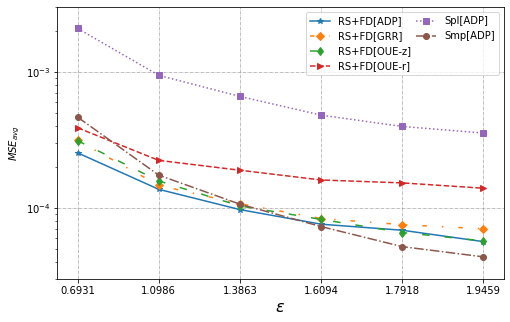

In [29]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(vhs_rs_fd_adp.mean(), label='RS+FD[ADP]', marker='*')
plt.plot(vhs_rs_fd_grr.mean(), label='RS+FD[GRR]', marker='D', linestyle=(0, (3, 10, 1, 10)))
plt.plot(vhs_rs_fd_oue_z.mean(), label='RS+FD[OUE-z]',marker='d',linestyle=(0, (5, 10)))
plt.plot(vhs_rs_fd_oue_r.mean(), label='RS+FD[OUE-r]',marker='>',linestyle='dashed')
plt.plot(vhs_spl_adp.mean(), label='Spl[ADP]',marker='s',linestyle='dotted')
plt.plot(vhs_smp_adp.mean(), label='Smp[ADP]',marker='o',linestyle='dashdot')
plt.plot(range(1,len(lst_eps)+1),np.zeros(6), color='w', alpha=0, label=' ')

plt.yscale('log')
plt.xlabel('$\epsilon$', fontsize=16)
plt.ylabel('$MSE_{avg}$')
plt.xticks(range(1,len(lst_eps)+1), lst_eps)#['ln('+str(val)+')' for val in range(2,8)]
plt.ylim([3e-5,0.3e-2])
plt.legend(ncol=2, columnspacing=0.5);
# plt.savefig('fig_results_vhs.pdf',dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()